In [ ]:
# Works best with jupyter-notebook

In [1]:
%matplotlib notebook 
#%matplotlib widget 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
import math
import numpy as np

from spatialmath import *
from spatialmath.base import *

import roboticstoolbox as rtb
from roboticstoolbox import *

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# Lecture 6.7 Numeric Inverse Kinematics

In this notebook, we will begin to explore the numeric inverse kinematics for different robots.

---

Under the DHRobot class, we have a number of inverse kinemtic methods that we will study:
https://github.com/petercorke/robotics-toolbox-python/wiki/Kinematics
https://petercorke.github.io/robotics-toolbox-python/arm_dh.html

**Numeric method:**
- sol = ikine_LM(T, q0=None): Numerical inverse kinematics by Levenberg-Marquadt optimization (Robot superclass)

- sol = ikine_min(T, q0=None, qlim=True) which uses scipy.minimize with user cost function and stiffness. 

--- 

The elements of the tuple sol include at least:


Element   | Type 	      | Description 
:---|:---|:---
q 	      | ndarray (n)   | Joint coordinates for the solution, or None 
:---|:---|:---
success   | bool 	      | True if a solution found 
:---|:---|:---
reason 	  | str 	      | reason for failure 
:---|:---|:---
iterations| int 	      | number of iterations 
:---|:---|:---
residual  | float 	      | final value of cost function 

---

Note:

**numerical IK solvers** minimise a *scalar measure of error* between a starting and the desired end-effector pose. The measure is the squared-norm of a 6-vector comprising:

- translational error (a 3-vector)
- the orientation error as an Euler vector (angle/axis form encoded as a 3-vector

The starting joint angle configuration can be set to your current configuration or an entirely different guess. This can be passed into the q0 variable.

Numerical optimization is slower than analytical counterparts. For this toolbox, SciPy based mimimizers are used. They use a scalar cost measure and must *numerically compute a Jacobian* to find a solution. 


Let's start by creating a model for the Puma560 robot.

In [2]:
puma = rtb.models.DH.Puma560()
print(puma)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃θⱼ  ┃         dⱼ         ┃   aⱼ   ┃   ⍺ⱼ   ┃   q⁻    ┃   q⁺   ┃
┣━━━━╋━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃ q1 ┃ 0.6718299999999999 ┃      0 ┃  90.0° ┃ -160.0° ┃ 160.0° ┃
┃ q2 ┃                  0 ┃ 0.4318 ┃   0.0° ┃ -110.0° ┃ 110.0° ┃
┃ q3 ┃            0.15005 ┃ 0.0203 ┃ -90.0° ┃ -135.0° ┃ 135.0° ┃
┃ q4 ┃             0.4318 ┃      0 ┃  90.0° ┃ -266.0° ┃ 266.0° ┃
┃ q5 ┃                  0 ┃      0 ┃ -90.0° ┃ -100.0° ┃ 100.0° ┃
┃ q6 ┃                  0 ┃      0 ┃   0.0° ┃ -266.0° ┃ 266.0° ┃
┗━━━━┻━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━┻━━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
└─────┴─────┴

Plot with joint angles qn.

<IPython.core.display.Javascript object>


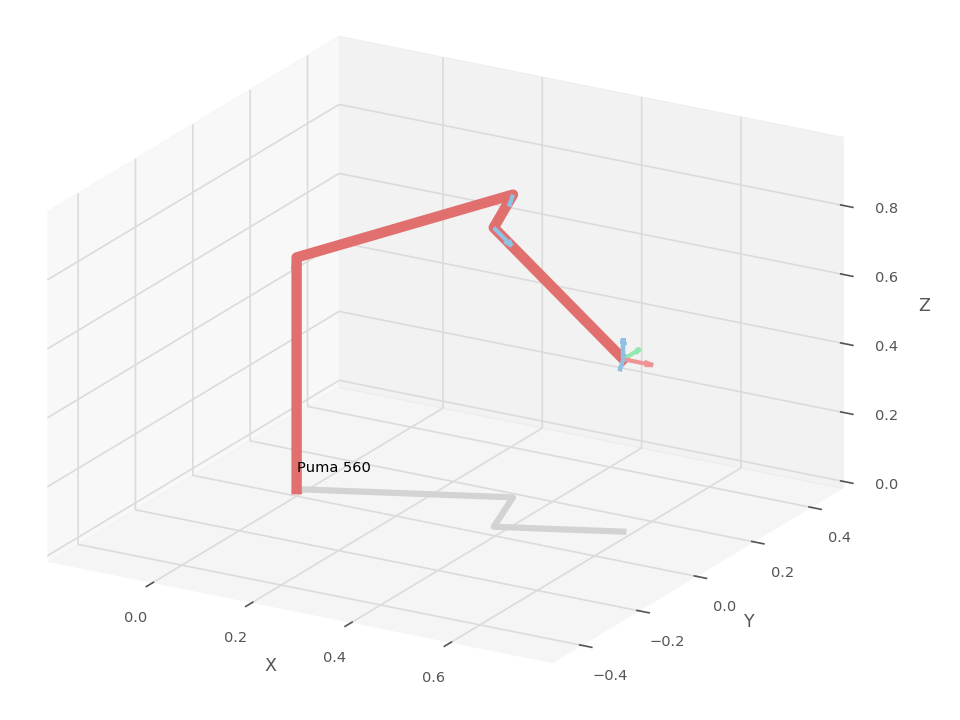

In [3]:
puma.plot(puma.qn);

Let us use the same example from before to designate a desired end-effector pose that we would like the puma robot to reach. 

In [4]:
T = SE3(0.6, 0.1, 0.5)*SE3().RPY([0, 0, 0], unit='deg')

print(type(T))
print(T)

<class 'spatialmath.pose3d.SE3'>
   1           0           0           0.6          
   0           1           0           0.1          
   0           0           1           0.5          
   0           0           0           1            



Plot the desired pose:

In [ ]:
trplot(T.A, dims=[-2,2], frame='EE', rviz=True); # Extracts numpy from T

This time however, we will use the numerical methods. Recall that our previous solution was equal to:
    - [3.057, 2.644,  0.03708, 0, -2.681, -3.057]

In [5]:
sol = puma.ikine_LM(T)
print(sol)

IKsolution(q=array([  0.4144,   -1.065,  0.03708,        0,    1.028,  -0.4144]), success=True, reason=None, iterations=11, residual=8.792828565994162e-13)


Let's plot this:

In [ ]:
puma.plot(sol.q);

The above solution is quite different from what we got in the analytical solution. It is an optimization optimization that may reach a configuration that is quite different than that of the analytical solution.  

To learn more lower-level details of the numerical algorithm check out the two additional videos on numerical IKin's I placed in our [youtube playlist](https://www.youtube.com/watch?v=VhUA0jf7tI8&list=PLts2VQxwm4sy6VIJVtLBWL5oJMoTqGXh5&index=18). 

Test starting from different locations?

In [7]:
sol = puma.ikine_LM(T, q0=puma.qn)
print(sol)

IKsolution(q=array([  0.4144,   0.4974,   -3.085,        0,    2.587,  -0.4144]), success=True, reason=None, iterations=10, residual=3.5478662408047905e-11)


The residual is lower but the error is still substantial... plot and visualize.

In [8]:
puma.plot(sol.q);

Furthermore, we are not able to choose a desired robot configuration, such as elbow-up...

We can do better when we have a goal configuration that is closer to the starting point.

As we did in notebook 6.6, we will create a sequences of desired joint angle configurations after using ctraj.\
Assign a final pose configuration:

In [9]:
TF = SE3(0.6, 0.1, 1.0)*SE3().RPY([0, 0, 0], unit='deg')

Interpolate in task space:

In [10]:
des_T = ctraj(T,TF,100)
print(len(des_T))

100


Compute ikine solns:

In [12]:
des_q = puma.ikine_LM(des_T)
print(des_q[99])

IKsolution(q=array([  0.4144,  -0.1673,  -0.1741,        0,   0.3414,  -0.4144]), success=True, reason=None, iterations=9, residual=2.126001214973701e-11)


Notice the lower error residual at the end... Why is this?

Get ready to plot. You will notice that the end-effector reaches the desired pose quite well.

In [13]:
q = np.array([ des_q[i].q for i in range(0,len(des_q))])
print(type(q))

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


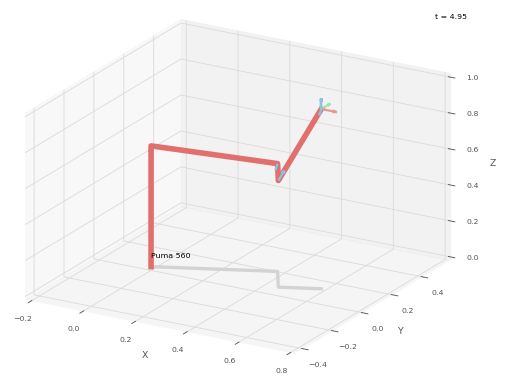

In [14]:
puma.plot(q);

### Student Exercise
Study the solutions for a spherical wrist: study how the change in orientation of the pose affects the 3 last joing angles of the robot, which control the orientation only. 

For example... test different configurations where you vary:

- the roll angle from -90 to 90
- the pictch angle from -90 to 90
- the yaw angle from -90 to 90

i.e. roll = a=np.linspace(-90,90,181)
````    
T = SE3(2.0, 0.1, 0.5)*SE3().RPY([roll, 0, 0], unit='deg')\
````